In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib.dates as mdates

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

import sys
# code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))
# sys.path.append(code_dir)
sys.path.append('../../../filecoin-mecha-twin/')

from jax import random
import numpyro.distributions as dist

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

In [2]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# Today is 2022-11-01
current_date = datetime.date(2022, 11, 1) 
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2022, 10, 30)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast is one year ahead from today
forecast_lenght = 365 * 3
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)
duration = 365 # sector duration

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

2022-10-30
2022-11-01
2025-10-31


In [3]:
# plot a column from the trajectory df
def plt_x(cil_df_summary, 
          quantity_to_plot='day_pledge_per_QAP', 
          scale_by=EIB, 
          smooth_by=1):  
    plt.rcParams.update({'font.size': 18})
    plt.rcParams["figure.figsize"] = (8,5)

    colors_ = [['peachpuff', 'tan', 'peru'], 
               ['powderblue', 'skyblue', 'steelblue'], 
               ['lightsalmon', 'tomato', 'firebrick']]
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)][quantity_to_plot] / scale_by
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)][quantity_to_plot] / scale_by
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)][quantity_to_plot] / scale_by
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)][quantity_to_plot] / scale_by
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)][quantity_to_plot] / scale_by
    
    plt.fill_between(dates_, q05_t.rolling(smooth_by).median(), q95_t.rolling(smooth_by).median(), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    plt.fill_between(dates_, q25_t.rolling(smooth_by).median(), q75_t.rolling(smooth_by).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    plt.plot(dates_, q50_t.rolling(smooth_by).median(), alpha=1, color=colors_[0][2], lw=2, label='Median')

    plt.xticks(rotation = 30)
    plt.title(f"{quantity_to_plot}")
    plt.legend(loc=2)
    plt.show()
    
# baseline crossing plots
def plt_blc(cil_df_summary, 
          quantity_to_plot='day_pledge_per_QAP', 
          scale_by=EIB, 
          smooth_by=1):
    # function to plot baseline crossing
    
    # define plot settings and palette
    plt.rcParams.update({'font.size': 18})
    plt.rcParams["figure.figsize"] = (18,18)
    colors_ = [['peachpuff', 'tan', 'peru'], 
               ['powderblue', 'skyblue', 'steelblue'], 
               ['lightsalmon', 'tomato', 'firebrick']]
    fig, axs = plt.subplots(4,2, constrained_layout=True)
    
    # select plotting data
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q5_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_RBP'] / scale_by
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_RBP'] / scale_by
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_RBP'] / scale_by
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_RBP'] / scale_by
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_RBP'] / scale_by
    # plot RBP predictions
    axs[0,0].fill_between(dates_, q5_t.rolling(smooth_by).median(), q95_t.rolling(smooth_by).median(), 
                     alpha=0.5, color=colors_[0][0], label='RBP Q90')
    axs[0,0].fill_between(dates_, q25_t.rolling(smooth_by).median(), q75_t.rolling(smooth_by).median(), 
                     alpha=0.65, color=colors_[0][1], label='RBP Q50')
    axs[0,0].plot(dates_, q50_t.rolling(smooth_by).median(), alpha=1, color=colors_[0][2], lw=2, label='RBP Median')
     # select plotting data
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q5_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_QAP'] / scale_by
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_QAP'] / scale_by
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_QAP'] / scale_by
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_QAP'] / scale_by
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_QAP'] / scale_by
    # plot QAP predictions
    axs[0,0].fill_between(dates_, q5_t.rolling(smooth_by).median(), q95_t.rolling(smooth_by).median(), 
                     alpha=0.5, color=colors_[1][0], label='QAP Q90')
    axs[0,0].fill_between(dates_, q25_t.rolling(smooth_by).median(), q75_t.rolling(smooth_by).median(), 
                     alpha=0.65, color=colors_[1][1], label='QAP Q50')
    axs[0,0].plot(dates_, q50_t.rolling(smooth_by).median(), alpha=1, color=colors_[1][2], lw=2, label='QAP Median')
    
    # plot baseline
    axs[0,0].plot(dates_, baseline, c='darkblue', label='baseline target')  
    axs[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    axs[0,0].tick_params(axis='x', labelrotation = 30)
    axs[0,0].legend(loc='upper right')
    axs[0,0].set_title('Baseline crossing')
    axs[0,0].set_ylabel('EiB')
    
    # plot baseline crossing PDF
    axs[0,1].hist(date_cross_samples,
                bins=100,
                density=True,
                label='Baseline crossing PDF', color=colors_[0][0])
    cross_q50 = pd.Series(date_cross_samples).quantile(0.5, interpolation="midpoint")
    axs[0,1].axvline(cross_q50, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Median {str(cross_q50)}')
    cross_q95 = pd.Series(date_cross_samples).quantile(0.95, interpolation="midpoint")
    axs[0,1].axvline(cross_q95, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Q95 {str(cross_q95)}')
    cross_q5 = pd.Series(date_cross_samples).quantile(0.05, interpolation="midpoint")
    axs[0,1].axvline(cross_q5, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Q5 {str(cross_q5)}')
    axs[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axs[0,1].tick_params(axis='x', labelrotation = 30)
    axs[0,1].set_title('Crossing empirical PDF')
    axs[0,1].legend(loc='upper right')

    # plot pledge per sector
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_pledge_per_QAP'] / 1
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_pledge_per_QAP'] / 1
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_pledge_per_QAP'] / 1
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_pledge_per_QAP'] / 1
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_pledge_per_QAP'] / 1
    axs[1,0].fill_between(dates_, q05_t.rolling(60).median(), q95_t.rolling(60).median(), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[1,0].fill_between(dates_, q25_t.rolling(60).median(), q75_t.rolling(60).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[1,0].plot(dates_, q50_t.rolling(60).median(), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[1,0].tick_params(axis='x', labelrotation = 30)
    axs[1,0].set_title('Pledge per 32 GiB')
    axs[1,0].legend(loc='upper right')
    axs[1,0].set_ylabel('FIL')
    
    # plot network reward
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_network_reward'] 
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_network_reward'] 
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_network_reward'] 
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_network_reward']
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_network_reward']
    axs[1,1].fill_between(dates_, q05_t.rolling(7).median(), q95_t.rolling(7).median(), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[1,1].fill_between(dates_, q25_t.rolling(7).median(), q75_t.rolling(7).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[1,1].plot(dates_, q50_t.rolling(7).median(), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[1,1].tick_params(axis='x', labelrotation = 30)
    axs[1,1].set_title('Minting')
    axs[1,1].legend(loc='upper right')
    axs[1,1].set_ylabel('FIL/day')
    
    
    # plot roi
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['1y_sector_roi'] * 100
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['1y_sector_roi']  * 100
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['1y_sector_roi'] * 100
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['1y_sector_roi'] * 100
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['1y_sector_roi'] * 100
    axs[2,1].fill_between(dates_, q05_t.rolling(7).median(), q95_t.rolling(7).median(), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[2,1].fill_between(dates_, q25_t.rolling(7).median(), q75_t.rolling(7).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[2,1].plot(dates_, q50_t.rolling(7).median(), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[2,1].tick_params(axis='x', labelrotation = 30)
    axs[2,1].set_title('1y sector ROI')
    axs[2,1].legend(loc='upper right')
    axs[2,1].set_ylabel('%')
    
    
    # plot daily locked pledge
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_locked_pledge'] 
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_locked_pledge'] 
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_locked_pledge'] 
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_locked_pledge']
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_locked_pledge']
    axs[2,0].fill_between(dates_, q05_t.rolling(7).median(), q95_t.rolling(7).median(), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[2,0].fill_between(dates_, q25_t.rolling(7).median(), q75_t.rolling(7).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[2,0].plot(dates_, q50_t.rolling(7).median(), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[2,0].tick_params(axis='x', labelrotation = 30)
    axs[2,0].set_title('Daily locked pledge')
    axs[2,0].legend(loc='upper right')
    axs[2,0].set_ylabel('FIL/day')
    
    # plot network locked
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_locked'] 
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_locked'] 
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_locked'] 
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_locked']
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_locked']
    axs[3,0].fill_between(dates_, q05_t.rolling(7).median(), q95_t.rolling(7).median(), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[3,0].fill_between(dates_, q25_t.rolling(7).median(), q75_t.rolling(7).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[3,0].plot(dates_, q50_t.rolling(7).median(), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[3,0].tick_params(axis='x', labelrotation = 30)
    axs[3,0].set_title('Network locked')
    axs[3,0].legend(loc='upper right')
    axs[3,0].set_ylabel('FIL')
    
    # plot lock / supply
    cil_df_summary['locked_over_supply'] = cil_df_summary['network_locked'] / cil_df_summary['circ_supply']
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['locked_over_supply'] * 100
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['locked_over_supply'] * 100
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['locked_over_supply'] * 100
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['locked_over_supply'] * 100
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['locked_over_supply'] * 100
    axs[3,1].fill_between(dates_, q05_t.rolling(7).median(), q95_t.rolling(7).median(), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[3,1].fill_between(dates_, q25_t.rolling(7).median(), q75_t.rolling(7).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[3,1].plot(dates_, q50_t.rolling(7).median(), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[3,1].tick_params(axis='x', labelrotation = 30)
    axs[3,1].set_title('Locked / Supply')
    axs[3,1].legend(loc='upper right')
    axs[3,1].set_ylabel('%')
    
    plt.show()

In [4]:
# simulation
# seperating from the expensive MCMC loop
def preprocess_expirations():
    # expirations
    res = get_sector_expiration_stats(start_date, current_date,end_date)

    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]

    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]

    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0
    
    return rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df

def get_historical_renewal_rate(current_date,start_date)->np.array:
    df_renewal_rate_orig = pd.read_csv('./offline_info/Scheduled_Expiration_by_Date_Breakdown_in_FIL.csv', 
                                       parse_dates=['stateTime'])
    df_renewal_rate = df_renewal_rate_orig.copy()
    df_renewal_rate['Renewal_Rate'] = df_renewal_rate['Extend'] / (df_renewal_rate['Extend'] 
                                 + df_renewal_rate['Expired']
                                 + df_renewal_rate['Potential Expire'])
    df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime <= str(current_date)]
    df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime >= str(start_date)]
    historical_renewal_rate = df_renewal_rate.Renewal_Rate.values
    return historical_renewal_rate

def run_sim(fil_plus_rate:float, 
            rb_onboard_power:float, 
            renewal_rate:float)->pd.DataFrame():
    future_renewal_rate_val = renewal_rate
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                (end_day - start_day) - len(historical_renewal_rate))
    # Renewal rate must now be a vector the length of the simulation
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])
    
    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec,
        fil_plus_rate,
        duration,
        forecast_lenght
    )
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )

    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values
    
    # minting 
    mint_df = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
    )

    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df,
        known_scheduled_pledge_release_full_vec
    )
    
    return cil_df

# sampling
def get_uniform_samples(central_estimate:float, 
                UR:float = 0.5, 
                n_samples:int = 100,
                key:int = 666,)->np.array:
    rng_key = random.split(random.PRNGKey(key))
    samples = dist.Uniform(central_estimate*(1-UR),
                           central_estimate*(1+UR)).expand([n_samples]).sample(rng_key[0])
    return np.array(samples)

def generate_prior_samples(n_samples=10, UR=0.5, 
                           fil_plus_rate_central=0.25, 
                           rb_onboard_power_central=8, 
                           renewal_rate_central=0.5)->pd.DataFrame:
    fil_plus_rate_samples = get_uniform_samples(central_estimate=fil_plus_rate_central, 
                                        UR=UR, 
                                        n_samples=n_samples)
    rb_onboard_power_samples = get_uniform_samples(central_estimate=rb_onboard_power_central, 
                                        UR=UR, 
                                        n_samples=n_samples)
    renewal_rate_samples = get_uniform_samples(central_estimate=renewal_rate_central, 
                                        UR=UR, 
                                        n_samples=n_samples)
    samples_df = pd.DataFrame({'fil_plus_rate': fil_plus_rate_samples,
                               'rb_onboard_power': rb_onboard_power_samples,
                               'renewal_rate': renewal_rate_samples})
    return samples_df

def run_sim_mc(samples_df)->pd.DataFrame:
    cil_df_i, cil_df = pd.DataFrame(), pd.DataFrame()
    for i in samples_df.index:
        if i % 10 == 0:
            print(f'{i} / {len(samples_df)}')
        fil_plus_rate = samples_df['fil_plus_rate'].iloc[i]
        rb_onboard_power = samples_df['rb_onboard_power'].iloc[i]
        renewal_rate = samples_df['renewal_rate'].iloc[i]
        cil_df_i = run_sim(fil_plus_rate, rb_onboard_power, renewal_rate)
        cil_df_i['iter'] = i
        cil_df_i['fil_plus_rate'] = fil_plus_rate
        cil_df_i['rb_onboard_power'] = rb_onboard_power
        cil_df_i['renewal_rate'] = renewal_rate
        cil_df = cil_df.append(cil_df_i)

    cil_df.index = cil_df.date
    cil_df.drop('date',axis=1,inplace=True)
    return cil_df

# baseline storage function
def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

# summary statistics of trajectory dynamics
def get_df_summary(df)->pd.DataFrame:
    df_summary = df.groupby(['date']).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])
    df_summary.rename(columns = {'level_1':'quantile'}, inplace = True)
    return df_summary

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
        xing = np.append(xing,xing_i)
    return xing

# add ROI to trajectory
def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
    df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
    df['1y_return_per_sector'] = df[['iter','day_rewards_per_sector']].groupby('iter').rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    return df

In [5]:
# separate expensive preprocessing from MCMC loop
rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df = preprocess_expirations()
vest_df = compute_vesting_trajectory_df(start_date, end_date)
historical_renewal_rate = get_historical_renewal_rate(current_date,start_date)

# Use parameters distributions fitted from from data

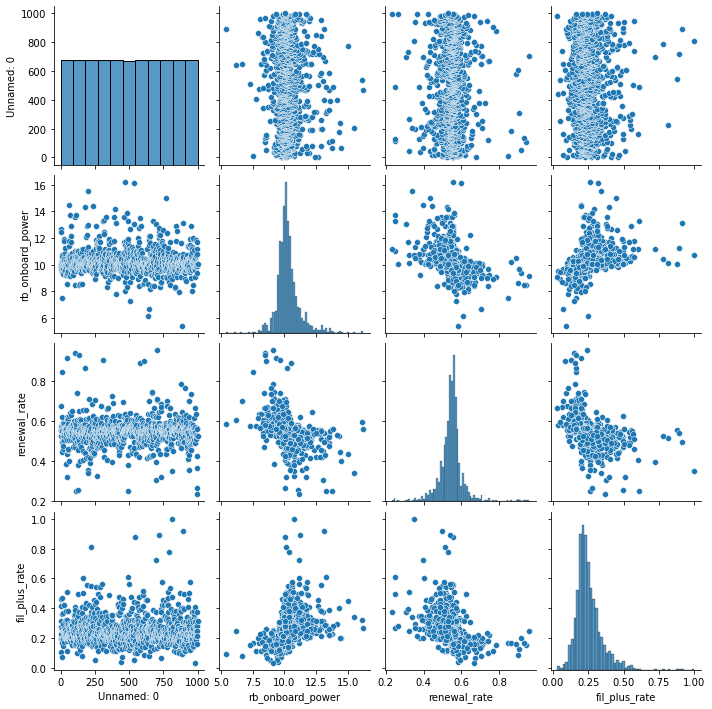

In [6]:
# from Distributions_to_parameterise_baseline_crossing_model.ipynb
model_samples_df = pd.read_csv('./offline_info/df_distributions_for_power_model_parameters.csv')
sns.pairplot(model_samples_df)

In [7]:
model_samples_df.describe()

,Unnamed: 0,rb_onboard_power,renewal_rate,fil_plus_rate
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,10.278504,0.546472,0.254776
std,288.819436,0.996297,0.068374,0.099633
min,0.000000,5.398259,0.231586,0.032804
25%,249.750000,9.773039,0.520090,0.196851
50%,499.500000,10.122833,0.548998,0.233857
75%,749.250000,10.573230,0.569724,0.292530
max,999.000000,16.226297,0.957074,1.000000


In [9]:
# simulate trajectories
# warning this takes ~15min for 500 samples 
n_samples = 500
cil_df2 = run_sim_mc(model_samples_df[:n_samples])

# find baseine storage function and crossings
cil_df2_mean = cil_df2.groupby('date').mean()
baseline = baseline_storage(cil_df2_mean.days_x * EPOCH_PER_DAY)
date_cross_samples = find_crossings(cil_df2)

# add ROI & summary
cil_df2_roi = add_generated_quantities(cil_df2)
cil_df2_summary = get_df_summary(cil_df2_roi)

0 / 500
10 / 500
20 / 500
30 / 500
40 / 500
50 / 500
60 / 500
70 / 500
80 / 500
90 / 500
100 / 500
110 / 500
120 / 500
130 / 500
140 / 500
150 / 500
160 / 500
170 / 500
180 / 500
190 / 500
200 / 500
210 / 500
220 / 500
230 / 500
240 / 500
250 / 500
260 / 500
270 / 500
280 / 500
290 / 500
300 / 500
310 / 500
320 / 500
330 / 500
340 / 500
350 / 500
360 / 500
370 / 500
380 / 500
390 / 500
400 / 500
410 / 500
420 / 500
430 / 500
440 / 500
450 / 500
460 / 500
470 / 500
480 / 500
490 / 500


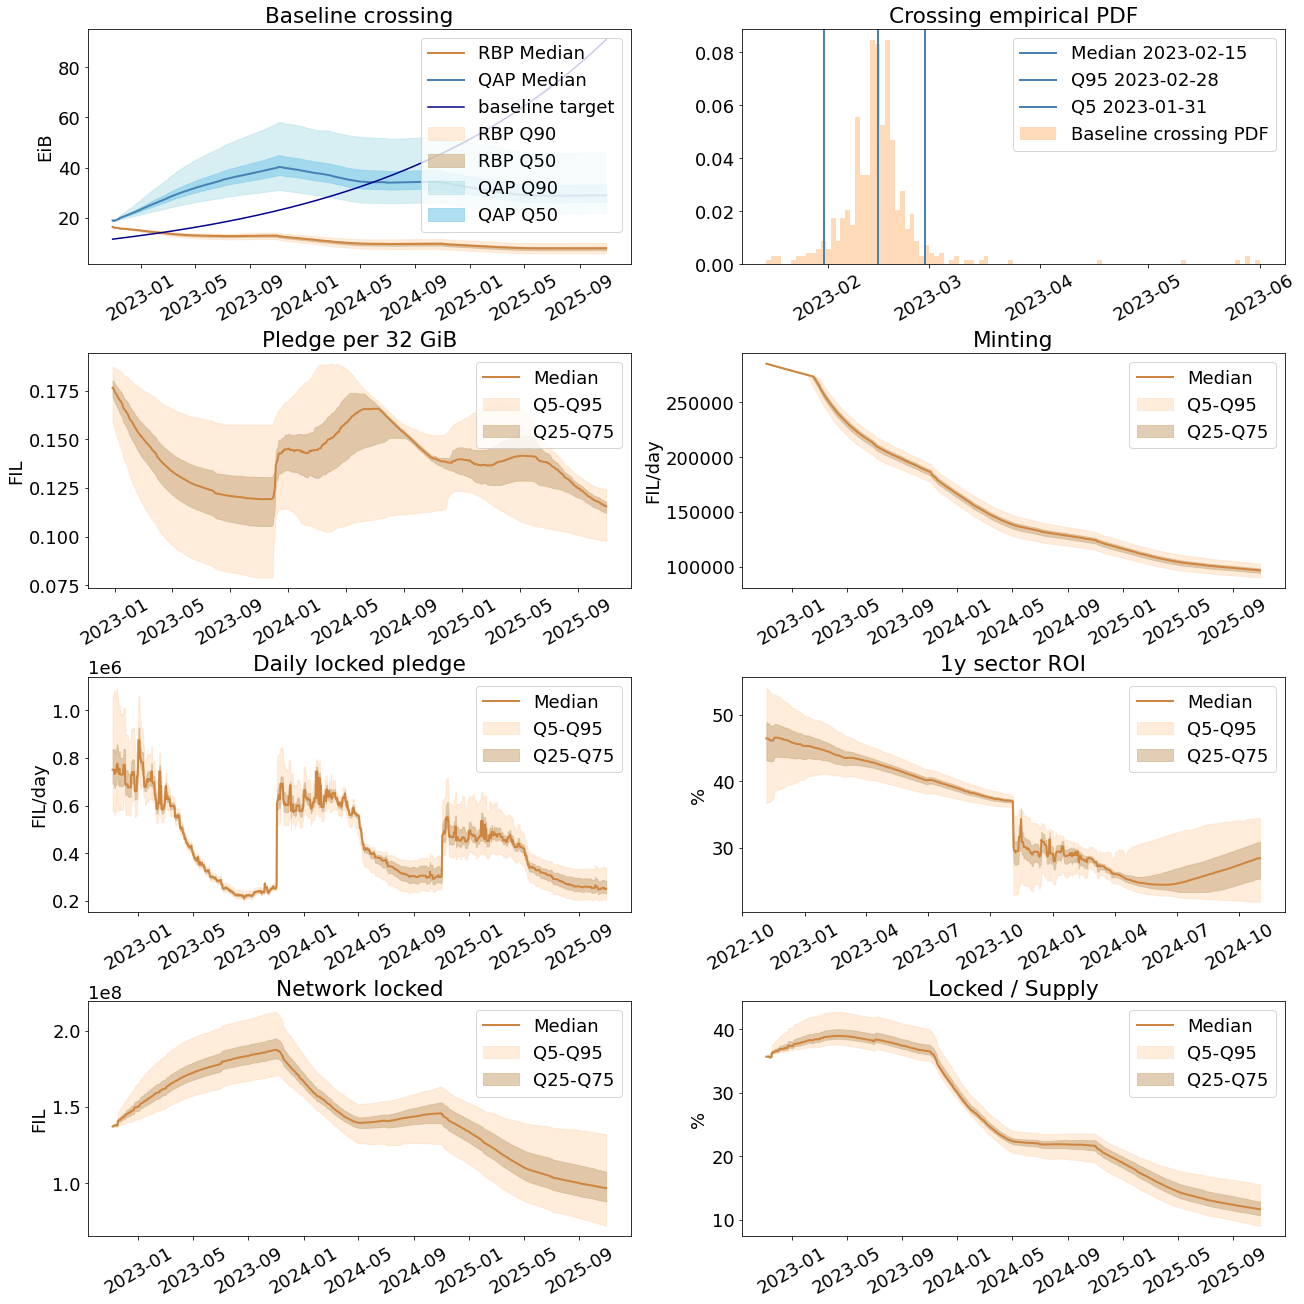

In [10]:
plt_blc(cil_df2_summary, 
          quantity_to_plot='network_RBP', 
          scale_by=EIB)

# Test parameters sampled from uniform distribution for selected scenarios

## Example 1

0 / 10


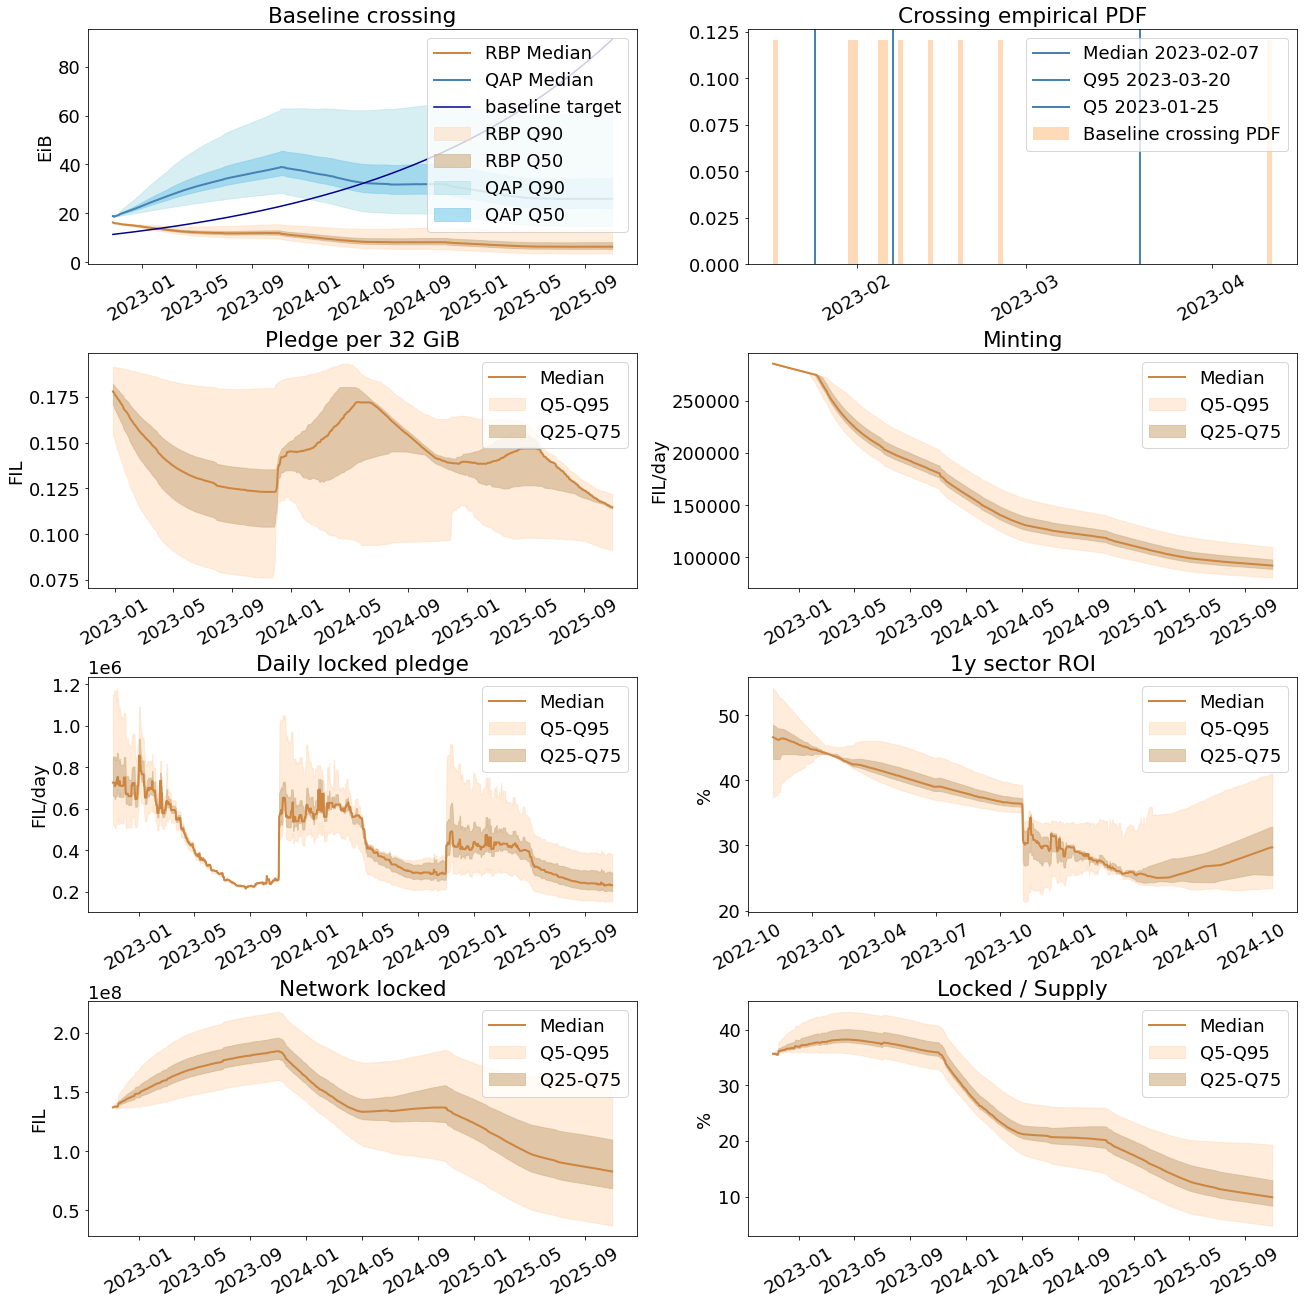

In [11]:
fil_plus_rate_central=0.25
rb_onboard_power_central=10
renewal_rate_central=0.5
UR=0.5 # % uncertainty about ^ assumptions
n_samples=10 # number of MC samples
prior_samples_df = generate_prior_samples(n_samples, 
                                          UR, 
                                          fil_plus_rate_central, 
                                          rb_onboard_power_central, 
                                          renewal_rate_central)

# simulate trajectories
cil_df = run_sim_mc(prior_samples_df)

# find baseine storage function and crossings
cil_df_mean = cil_df.groupby('date').mean()
baseline = baseline_storage(cil_df_mean.days_x * EPOCH_PER_DAY)
date_cross_samples = find_crossings(cil_df)

# add ROI & summary
cil_df_roi = add_generated_quantities(cil_df)
cil_df_summary = get_df_summary(cil_df_roi)

# plot
plt_blc(cil_df_summary, 
          quantity_to_plot='network_RBP', 
          scale_by=EIB)

## Example 2

0 / 10


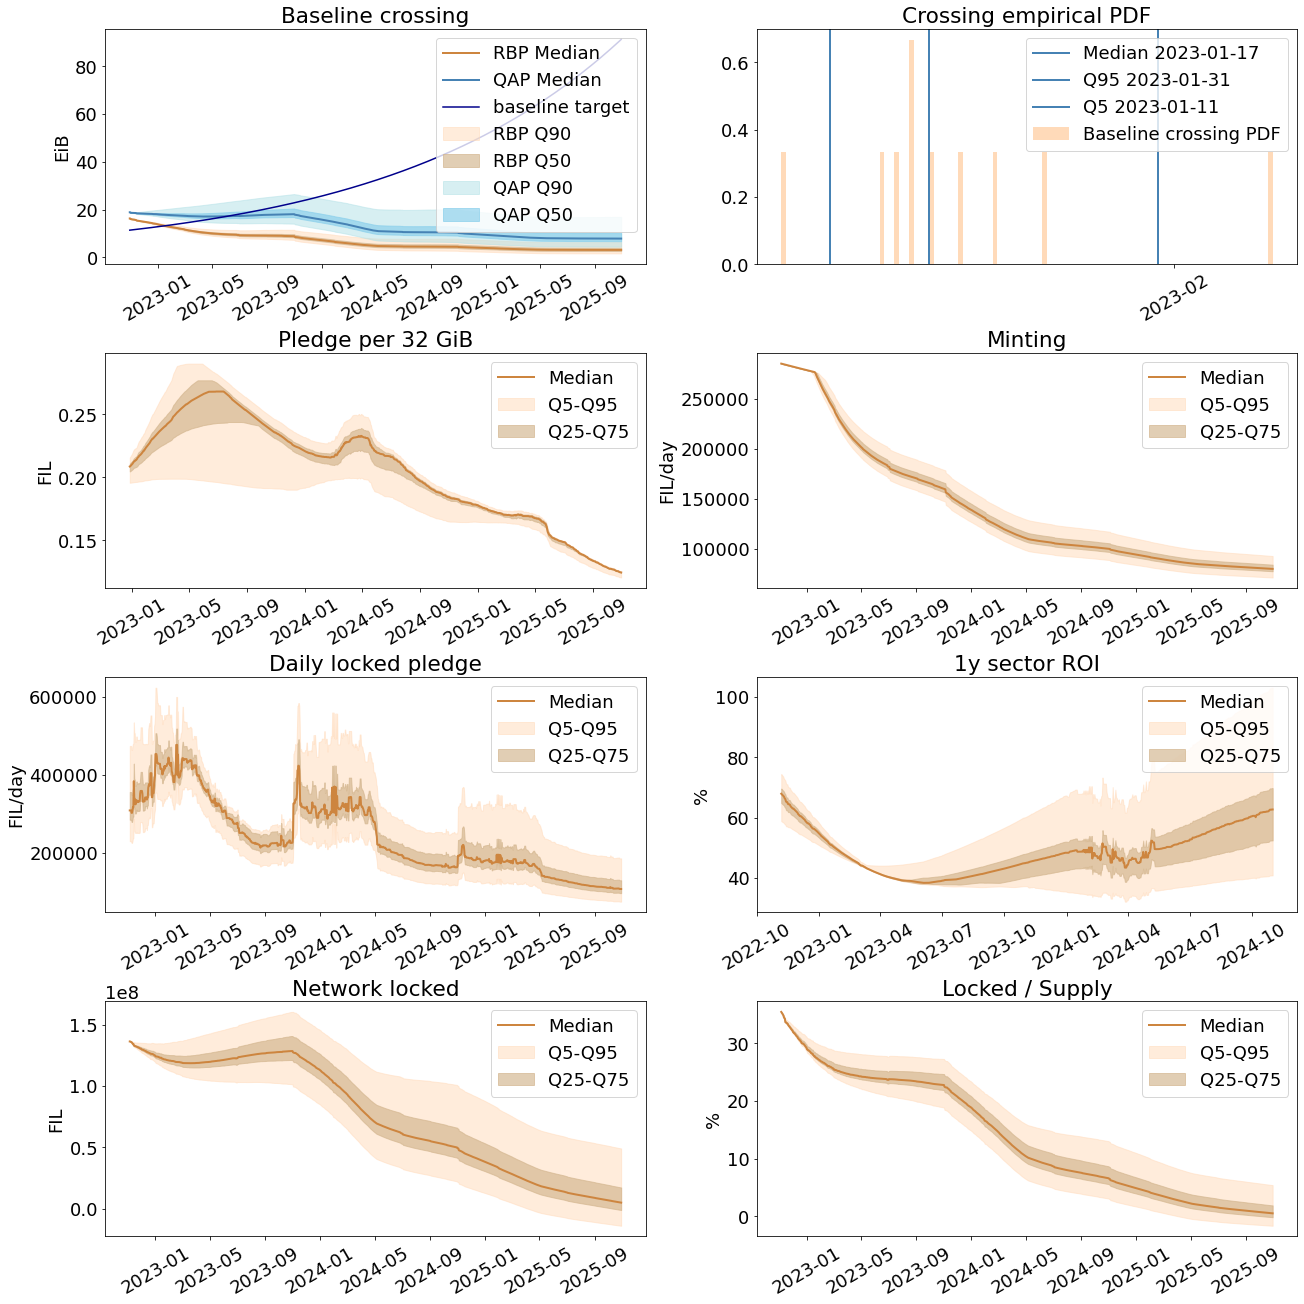

In [12]:
fil_plus_rate_central=0.1
rb_onboard_power_central=10
renewal_rate_central=0.3
UR=0.5 # % uncertainty about ^ assumptions
n_samples=10 # number of MC samples
prior_samples_df = generate_prior_samples(n_samples, 
                                          UR, 
                                          fil_plus_rate_central, 
                                          rb_onboard_power_central, 
                                          renewal_rate_central)

# simulate trajectories
cil_df = run_sim_mc(prior_samples_df)

# find baseine storage function and crossings
cil_df_mean = cil_df.groupby('date').mean()
baseline = baseline_storage(cil_df_mean.days_x * EPOCH_PER_DAY)
date_cross_samples = find_crossings(cil_df)

# add ROI & summary
cil_df_roi = add_generated_quantities(cil_df)
cil_df_summary = get_df_summary(cil_df_roi)

# plot
plt_blc(cil_df_summary, 
          quantity_to_plot='network_RBP', 
          scale_by=EIB)